In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import library

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from scipy.stats import norm
from tqdm.auto import tqdm

import sys

sys.path.append("../utils")
from utils import *
from data_retrieve import *
from gbm import *

## Define variables

In [49]:
last_id = 287
backtest_start = 187
backtest_end = 252

price_method = list()
var_method = list()

sim_list = [
    (MultivariateGBMSimulationTS, {'n_paths': 10000, 'window_size': 30, 'implied_volatility': True}, {'risk_neutral': False, 'verbose': False}),
    # (MultivariateGBMSimulationTS, {'n_paths': 10000, 'window_size': 30, 'implied_volatility': False}, {'risk_neutral': False, 'verbose': False}),
    (MultivariateGBMSimulationAV, {'n_paths': 10000, 'window_size': 30, 'implied_volatility': True}, {'risk_neutral': True, 'verbose': False}),
    (MultivariateGBMSimulation, {'n_paths': 10000, 'window_size': 30, 'implied_volatility': False}, {'risk_neutral': True, 'verbose': False})
]

## Run simulations

In [ ]:
for func, sim_params, payoff_params in sim_list:
    prices = []
    prices_var = []

    for current_id in range(backtest_start, backtest_end):
        payoff = []
        result, _, discounts = func(
            s0=close.iloc[current_id],
            current_id=current_id,
            **sim_params
        )

        old_path_rog = combined_df["ROG_Last_Price"].iloc[:current_id]
        old_path_cfr = combined_df["CFR_Last_Price"].iloc[:current_id]
        old_path_zurn = combined_df["ZURN_Last_Price"].iloc[:current_id]

        path_rog = []
        path_cfr = []
        path_zurn = []
        
        for i in range(result.shape[-2]):
            path_rog.append(np.append(old_path_rog, result[0][i].flatten()))
            path_cfr.append(np.append(old_path_cfr, result[1][i].flatten()))
            path_zurn.append(np.append(old_path_zurn, result[2][i].flatten()))

        payoff = payoff_func_parallel(
            path_rog,
            path_cfr,
            path_zurn,
            combined_df.iloc[current_id]["Date"],
            risk_free=discounts,
            **payoff_params
        )

        prices.append(np.mean(payoff))
        prices_var.append(np.var(payoff))

    price_method.append(prices)
    var_method.append(prices_var)


## Visualization

114.40215923201995
1188.9209220754944
1181.241250291632


d:\mh4518_simulation_in_fin\main\../utils\utils.py:241: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  real_price['Date'] = pd.to_datetime(real_price['Date'], dayfirst=True)


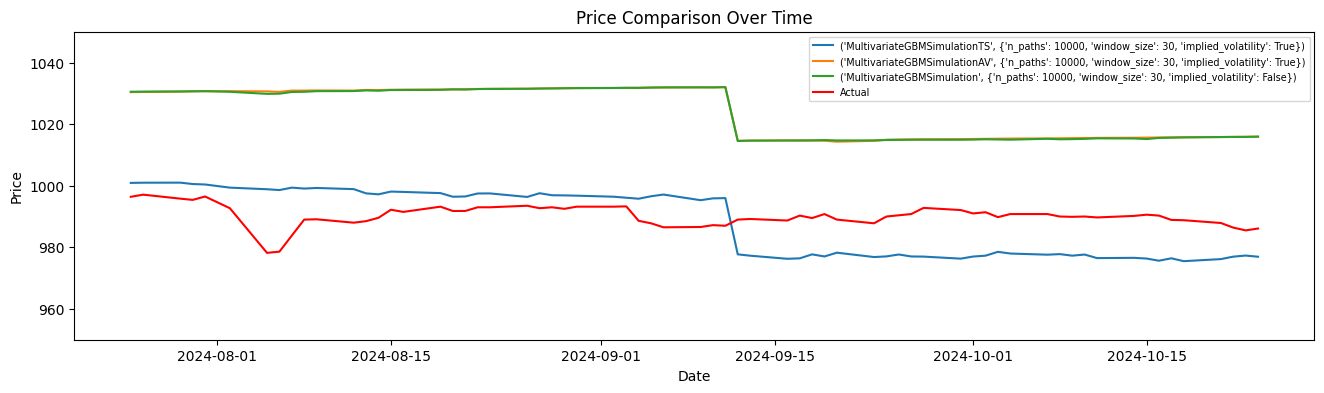

In [52]:
legend_list = [(element[0].__name__, element[1]) for element in sim_list] + ['Actual']
combined_df = retrieve_data()
evaluation_plot(backtest_start, backtest_end, combined_df, price_method, ylim=(950, 1050))
plt.legend(legend_list, fontsize='x-small')